In "frame_rotation.ipynb" we computed principal angles across layers and the dimension using Matrix theory and Marchenko-Pastur distribution.

Now we move on and evaluate the amount of space our buffer explores during the transformation, we will use different types of metrics.

In [2]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS


In [3]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

model.eval()    # Set to evaluation mode: Turns off dropout, ensuring deterministic outputs; Freezes running statistics (in LayerNorm).

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
prompts = {
    "closed": [
    "Water freezes at 0 degrees",
    "The author of Romeo and Juliet is", 
    "Einstein is best known for the theory of",
    "Brazil's official language is",
    "Jupiter is the largest",
    "Gold’s chemical symbol is",
    "Opposite in meaning to 'hot' is",
    "Where is the Great Wall located?",
    "Tokyo is the capital of",
    "A triangle has how many sides?",
    "The boiling point of water in Celsius is",
    "Who painted the Mona Lisa?",
    "Pi is approximately equal to",
    "Mount Everest is located in which country?",
    "The organ responsible for pumping blood throughout the body is the"
    ]
}

target_answers = {
    "Water freezes at 0 degrees": "Celsius",
    "The author of Romeo and Juliet is": "Shakespeare",
    "Einstein is best known for the theory of": "relativity",
    "Brazil's official language is": "Portuguese",
    "Jupiter is the largest": "planet",
    "Gold’s chemical symbol is": "Au",
    "Opposite in meaning to 'hot' is": "cold",
    "Where is the Great Wall located?": "China",
    "Tokyo is the capital of": "Japan",
    "A triangle has how many sides?": "3",
    "The boiling point of water in Celsius is": "100",
    "Who painted the Mona Lisa?": "Leonardo",
    "Pi is approximately equal to": "3.14",
    "Mount Everest is located in which country?": "Nepal",
    "The organ responsible for pumping blood throughout the body is the" : "heart"
}


In [5]:
prompt = prompts["closed"][2]
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")

# Containers for layer outputs
embedding_outputs = []
attention_outputs = []
mlp_outputs = []
ln1_outputs = []
ln2_outputs = []

# Hook functions to capture intermediate activations
def get_embedding_output(module, input, output):
    embedding_outputs.append(output.detach())

def get_attention_output(module, input, output):
    attention_outputs.append(output[0].detach())

def get_mlp_output(module, input, output):
    mlp_outputs.append(output.detach())

def get_ln1_output(module, input, output):
    ln1_outputs.append(output.detach())

def get_ln2_output(module, input, output):
    ln2_outputs.append(output.detach())


# Register forward hooks
model.transformer.drop.register_forward_hook(get_embedding_output)
#model.transformer.wpe.register_forward_hook(get_embedding_output)

for block in model.transformer.h:
    block.ln_1.register_forward_hook(get_ln1_output)
    block.attn.register_forward_hook(get_attention_output)
    block.ln_2.register_forward_hook(get_ln2_output)
    block.mlp.register_forward_hook(get_mlp_output)

model.transformer.ln_f.register_forward_hook(get_ln1_output)

# Clear stored outputs before a new forward pass
embedding_outputs.clear()
attention_outputs.clear()
mlp_outputs.clear()
ln1_outputs.clear()
ln2_outputs.clear()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]
seq_len=logits.shape[1]

hidden_dim = ln1_outputs[0][0].shape[1]


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Tokens:
 0: E
 1: instein
 2: Ġis
 3: Ġbest
 4: Ġknown
 5: Ġfor
 6: Ġthe
 7: Ġtheory
 8: Ġof


## See most probable next token, entropy and attention at each layer

Prompt: Einstein is best known for the theory of

[Attention] Layer  0: Last Token Entropy 1.2889, Mean Entropy 2.5539
   1:       Ġthe (0.8244)
   2:         Ġ" (0.1034)
   3:         Ġa (0.0194)
   4:         Ġ' (0.0040)
   5:         ĠD (0.0021)
   6:      Ġmore (0.0021)
   7:         ĠL (0.0016)
   8:     Ġfirst (0.0016)
   9:     Ġother (0.0016)
  10:        Ġan (0.0015)
[Attention] Layer  1: Last Token Entropy 14.4204, Mean Entropy 12.3701
   1:        ©¶æ (0.0037)
   2:  SPONSORED (0.0023)
   3:     sonian (0.0017)
   4:   catentry (0.0016)
   5:     Ġfixme (0.0015)
   6:   Streamer (0.0014)
   7: Ġpractition (0.0012)
   8: ĠFlavoring (0.0012)
   9: natureconservancy (0.0012)
  10:     soType (0.0012)
[Attention] Layer  2: Last Token Entropy 13.7618, Mean Entropy 14.3985
   1:   Ġphysics (0.0078)
   2:  Ġtheories (0.0069)
   3: Ġunfolding (0.0032)
   4: Ġconvergence (0.0031)
   5:   Ġbeliefs (0.0025)
   6:   Ġtheorem (0.0025)
   7:  Ġcalculus (0.0022)
   8: Ġphotography (0.0021)

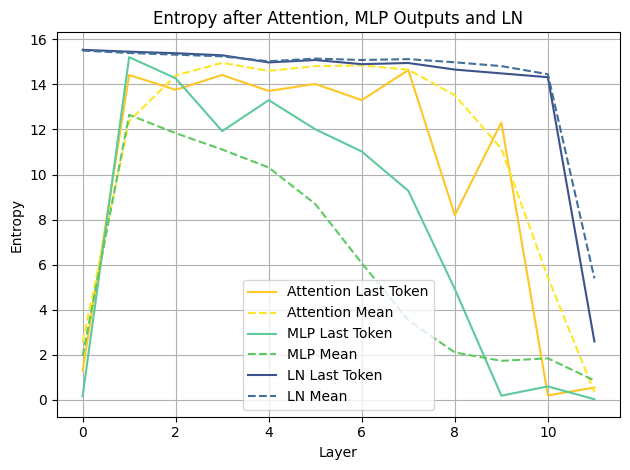

In [6]:
# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 10  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

temperature = 1.0  # Try 0.7 for sharper, or 1.5 for more diverse

def compute_entropy_from_outputs(outputs_list, label):
    entropy_last = []
    entropy_mean = []
    for i, layer_output in enumerate(outputs_list):
        hidden = layer_output  # shape: [1, seq_len, hidden_dim]
        last_token_vec = hidden[0, token_position, :]  # [hidden_dim]
        logits = lm_head(last_token_vec)
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
        
        entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
        entropy_last.append(entropy)

        all_logits = lm_head(hidden[0])  # shape: [seq_len, vocab_size]
        all_scaled_logits = all_logits / temperature
        all_probs = torch.softmax(all_scaled_logits, dim=-1)
        all_entropy = -torch.sum(all_probs * torch.log2(all_probs + 1e-12)).item()
        mean_entropy = all_entropy / all_probs.size(0)
        entropy_mean.append(mean_entropy)

        print(f"[{label}] Layer {i:2d}: Last Token Entropy {entropy:.4f}, Mean Entropy {mean_entropy:.4f}")
        for j in range(top_k):
            print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

    
    return entropy_last, entropy_mean

# Compute for attention and MLP outputs
attn_entropy_last, attn_entropy_mean = compute_entropy_from_outputs(attention_outputs, "Attention")
mlp_entropy_last, mlp_entropy_mean = compute_entropy_from_outputs(mlp_outputs, "MLP")
ln_entropy_last, ln_entropy_mean = compute_entropy_from_outputs(ln1_outputs, "LN")

# Plotting
plt.plot(attn_entropy_last, label="Attention Last Token", c= "#fdc725")
plt.plot(attn_entropy_mean,"--", label="Attention Mean", c='#fde725')
plt.plot(mlp_entropy_last, label="MLP Last Token", c="#5ec99b")
plt.plot(mlp_entropy_mean,"--", label="MLP Mean", c='#5ec962')
plt.plot(ln_entropy_last[1:], label="LN Last Token", c='#3b528b')
plt.plot(ln_entropy_mean[1:],"--", label="LN Mean", c="#426f9a")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.title("Entropy after Attention, MLP Outputs and LN")
plt.legend(loc='lower center')
plt.grid(True)
plt.tight_layout()
plt.show()


### Similarity measures with Target token

Interpretation:
Cosine similarity shows directional alignment — higher means more semantically aligned.

Euclidean distance shows absolute position closeness — lower means closer in space.

We compare with the 10 most probable tokens

In [ ]:
top_tokens = [
    "Ġrelativity", "Ġgravity", "Ġgeneral", "Ġgravitational", "Ġthe",
    "Ġquantum", "ĠGeneral", "Ġevolution", "ĠEinstein", "Ġgrav"
]

token_ids = tokenizer.convert_tokens_to_ids(top_tokens)
with torch.no_grad():
    top_embeddings = model.transformer.wte(torch.tensor([token_ids])).squeeze().numpy()

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


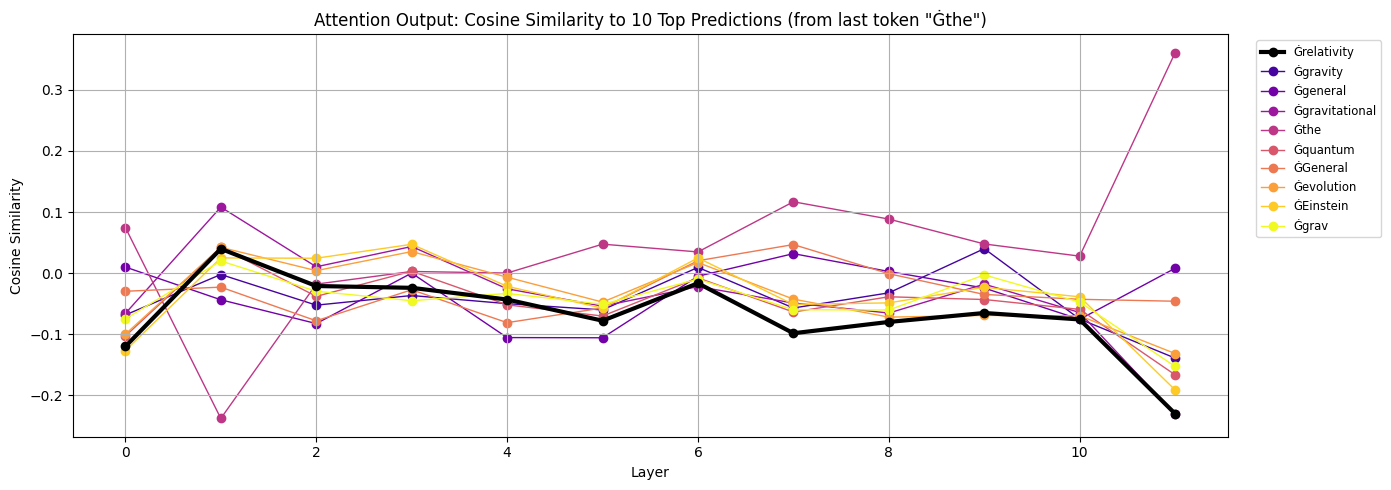

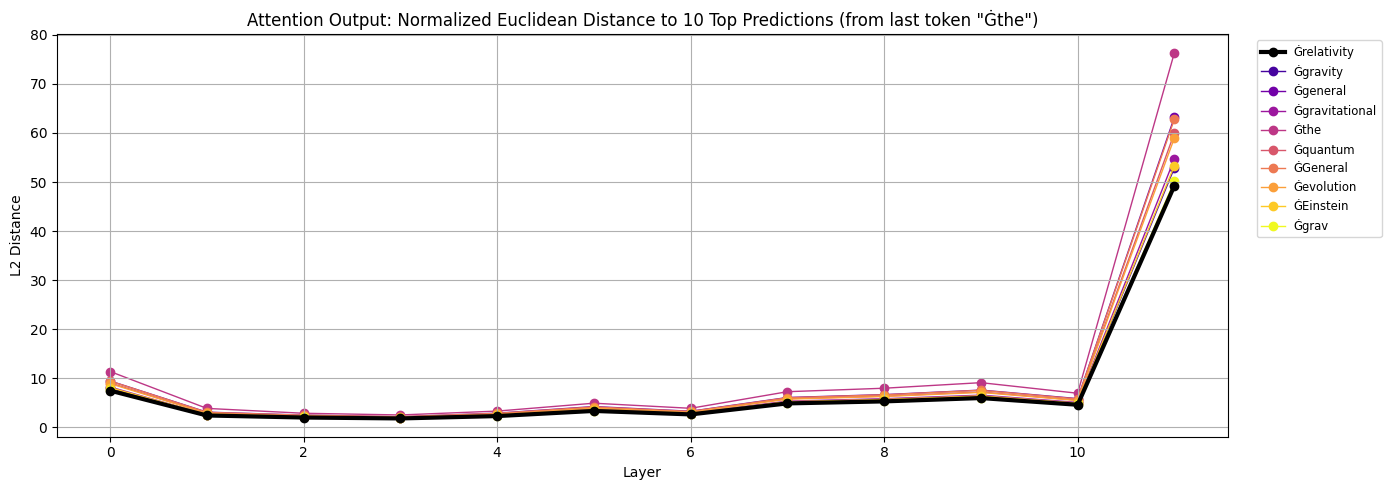

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


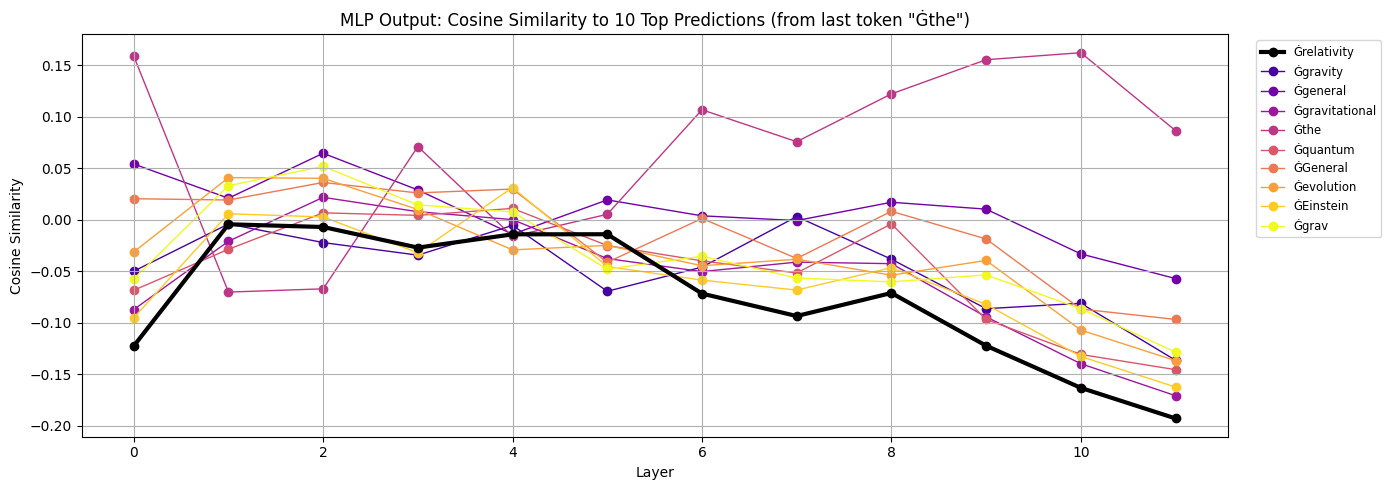

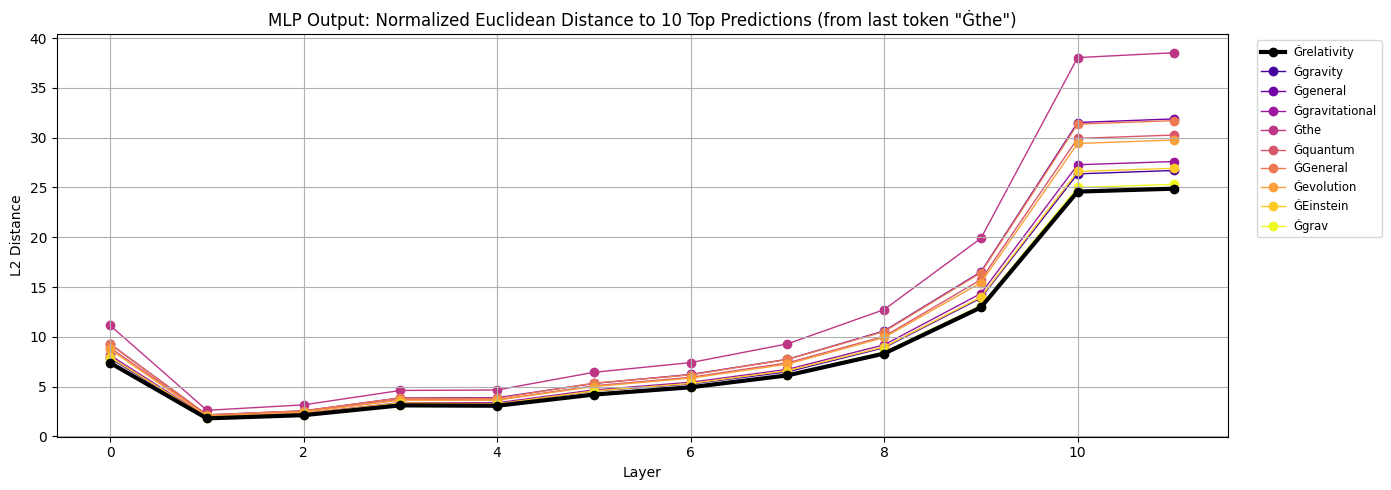

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


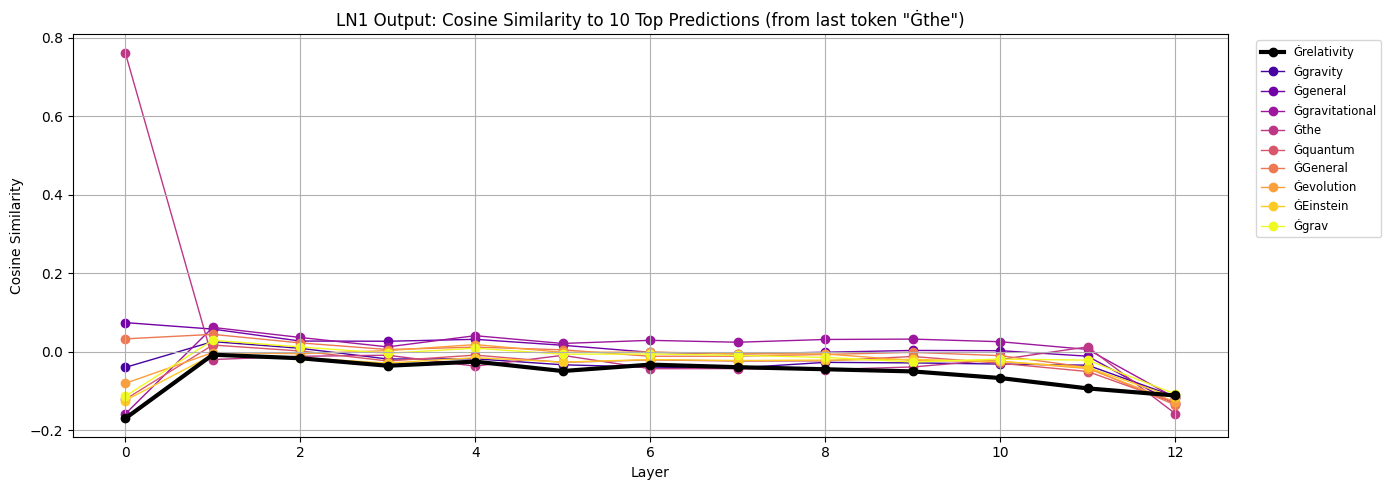

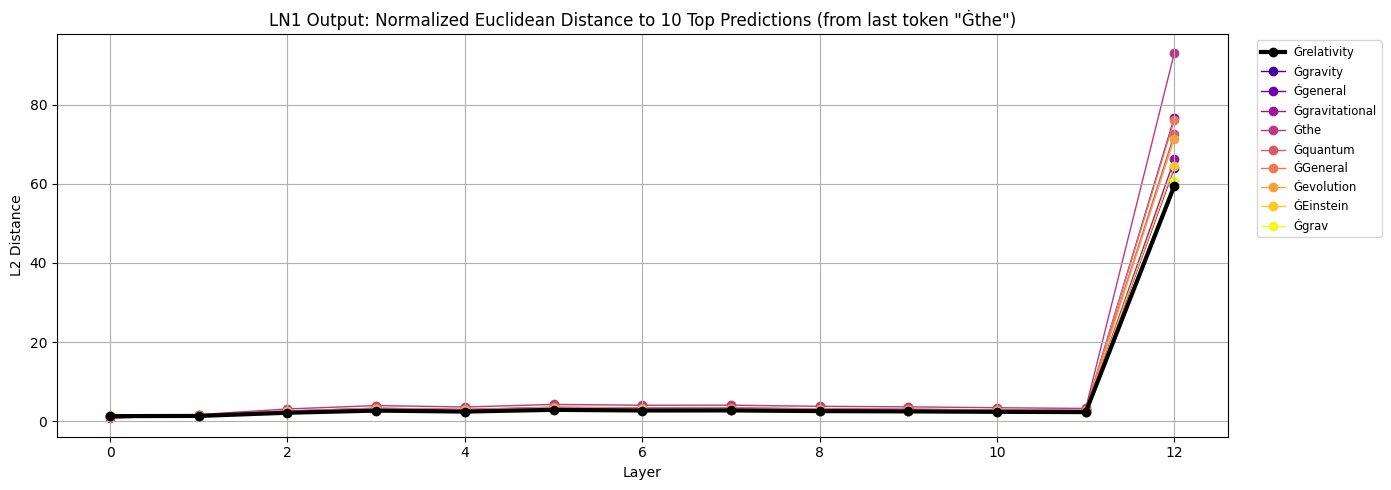

In [ ]:
def compare_multiple_targets(outputs_list, target_embeds, token_position, token_label, top_tokens, label):
    n_layers = len(outputs_list)
    cos_sims_all = []
    eucl_dists_all = []
    norm_eucl_dists_all = []

    for idx, target_embed in enumerate(target_embeds):
        cos_sims = []
        eucl_dists = []
        norm_eucl_dists = []
        for layer in range(n_layers):
            vec = outputs_list[layer][0, token_position].cpu().numpy()
            cos_sims.append(cosine_similarity([vec], [target_embed])[0][0])
            eucl_dists.append(np.linalg.norm(vec - target_embed))
            norm_diff = np.linalg.norm(vec - target_embed)
            norm_base = np.linalg.norm(target_embed)
            normalized_dist = norm_diff / (norm_base + 1e-8)  # Avoid division by zero
            norm_eucl_dists.append(normalized_dist)

        cos_sims_all.append(cos_sims)
        eucl_dists_all.append(eucl_dists)
        norm_eucl_dists_all.append(norm_eucl_dists)
        

    # Prepare colors from plasma colormap
    cmap = cm.get_cmap("plasma", len(top_tokens))
    colors = [cmap(i) for i in range(len(top_tokens))]

    # Plot Cosine Similarity
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(cos_sims_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Cosine Similarity to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


    # Plot normalized Euclidean Distance
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(norm_eucl_dists_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Normalized Euclidean Distance to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("L2 Distance")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return cos_sims_all, eucl_dists_all, norm_eucl_dists

token_position = -1
token_label = tokens[token_position]

# Run similarity comparison
attn_cos_all, attn_dist_all, _ = compare_multiple_targets(
    attention_outputs, top_embeddings, token_position, token_label, top_tokens, "Attention Output"
)

mlp_cos_all, mlp_dist_all, _ = compare_multiple_targets(
    mlp_outputs, top_embeddings, token_position, token_label, top_tokens, "MLP Output"
)

ln_cos_all, ln_dist_all, _ = compare_multiple_targets(
    ln1_outputs, top_embeddings, token_position, token_label, top_tokens, "LN1 Output"
)
